# Численный анализ сценариев: имитационный и аналитический подходы

В этом ноутбуке мы исследуем эффективность аналитической модели и сравним ее точность с имитационной моделью RFID.

Мы сравним и изучим три характеристики:

- распределение числа активных меток по раундам;
- оценки длительностей раундов;
- вероятность идентификации отдельной метки.

Первые две характеристики мы аналитически получим с помощью фонового процесса, а третью - с помощью основного процесса.

## Настройка ноутбука

Сначала подключим все нужные нам библиотеки, определим простые служебные функции и настроим библиотеку `matplotlib`.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Раскоментируйте следующие строки, чтобы установить нужные библиотеки:
#!pip install matplotlib
#!pip install tabulate
#!pip install seaborn

In [2]:
import os
import itertools                 # декартово произведение списков (product)
import numpy as np
import pandas as pd              # нужна для работы с данными моделирования
import matplotlib as mpl
import matplotlib.pyplot as plt  # графики
import seaborn as sns
from tqdm.notebook import tqdm   # с помощью tqdm будем изображать прогресс
from typing import Dict, Any
from tabulate import tabulate

from rfidam.simulation import ModelParams, build_scenario_info
from rfidam.chains import estimate_rounds_props, estimate_id_probs
from rfidam.cy_ext.simulation import simulate
from rfidam.protocol.protocol import LinkProps, Protocol
from rfidam.protocol import symbols
from rfidam.scenario import parse_scenario, mark_scenario
from rfidam.statistics import count_averages, group_round_values, StatsVector
from rfidam.utils import bcolors, get_err, fmt_err, highlight as hl, pluralize

In [5]:
%matplotlib inline
# Настроим Matplotlib: выберем цветовую схему и сделаем шрифты крупнее
CMAP = plt.get_cmap('viridis')
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20

Определим функции для форматирования вывода:

In [6]:
def fmt_header(s): return hl(s, bcolors.OKBLUE)
def fmt_delim(s): return hl(s, bcolors.OKCYAN)
def fmt_float(x): return f'{x:.4f}' 

def fmt_yesno(b): 
    return hl("Yes", bcolors.OKBLUE) if b else hl("No", bcolors.FAIL)

def rel_err(x, y):
    return abs(float(x - y) / y) if abs(y) > 1e-3 else abs(x / (1 + y))

## Параметры окружения

Все параметры, которые нам понадобятся в этом эксперименте, можно разделить на три группы:

- *гиперпараметры*: настройки (гиперпараметры) алгоритмов
- *метапараметры*: параметры модели, значения которых не существенно влияют на результаты, или 
- *свободные (переменные) параметры*: параметры, изменение которых наиболее существенно влияет на результаты

К *гиперпараметрам* относится, например, число моделируемых меток, или кратность расширенных сценариев. Такие параметры влияют на точность результатов и скорость расчетов.


*Метапараметры* - это те величины, которые сами по себе не оказывают существенного влияния на результаты, и для их различных значений можно подобрать диапазоны других (мета- и обычных) параметров, на которых будут получены близкие результаты. Например, так как в модели явно задается BER, то параметр `M` (число символов на бит в ответах меток) влияет только на длительность сообщений, поэтому, если для `M=8` взять большую область чтения и увеличить интервал между метками пропорционально, то можно получить тот же результат, что и для `M=1`, маленькой области чтения и коротких интервалов между поступлениями.
Большинство настроек RFID попадают в категорию метапараметров из-за того, что BER - свободный параметр.

*Свободные параметры* - это те параметры, которые наиболее существенно влияют на результат. К ним относятся сценарии работы считывателя, BER и интервалы между поступлениями меток.

### Гиперпараметры и настройки

В модели используется три гиперпараметра:

- число моделируемых меток;
- кратность расширенных сценариев;
- множитель раундов при свертке.

Кратность расширенных сценариев определяет, сколько раз копируется сценарий при построении расширенного сценария. Например, если сценарий задается строкой `"ABABx"`, а кратность равна пяти, то расширенный сценарий будет `"ABABxABABxABABxABABxABABx"`. Чем выше кратность, тем больше моментов поступления и выхода меток попадет в моделируемый (аналитической моделью) интервал, и тем точнее будет результат. Однако при этом растет сложность расчета.

Число моделируемых меток определяет, сколько событий поступлений новых меток будет моделироваться в имитации.

Множитель при свертке сценариев используется при исследовании характеристик раундов, там он будет описан подробнее.

> **ВНИМАНИЕ!** После загрузки из CSV гиперпараметры могут быть изменены на значения из файла.

In [7]:
N_SIM_TAGS = 3000           # число моделируемых меток
EXT_SCENARIO_MULT = 2000    # кратность расширенных сценариев
ROLL_SCENARIO_KOEF = 3      # множитель длины сценарии при свертывании

Также определим настройки исполнения модели:

- имя CSV-файла, из которого будут браться готовые данные (если он есть), или в который будут записаны результаты моделирования;
- флаг `FORCE_COMPUTE`, указывающий, что результаты надо обязательно пересчитать, независимо от того, существует ли CSV-файл;
- число рабочих (параллельных процессов), которые будут использоваться при моделировании.

Очень желательно делать число рабочих равным или немного меньшим числа ядер процессора.

Если флаг `FORCE_COMPUTE = False` и CSV-файл существует, то модели не будут пересчитываться, а данные и диапазоны свободных параметров будут загружены из файла.

In [8]:
CSV_FILE_NAME = os.path.join("data", "id_prob.csv")
FORCE_COMPUTE = False       # <-- !! Если True, то пересчитать все !!
N_WORKERS = 8               # число параллельных процессов

### Метапараметры

Метапараметры не влияют на результаты моделирования сами по себе, их значения влияют только на диапазон свободных параметров. К метапараметрам относятся:

- параметры передачи команд считывателя `Tari`, `RTcal`, `TRcal`
- параметры передачи ответов меток `M`, `DR`, `TREXT`
- длительность отключения считывателя `T_OFF`
- время нахождения метки в области чтения `TIME_IN_AREA`
- число читаемых слов из TID `N_DATA_WORDS` и размер EPCID в байтах `N_EPCID_BYTES`
- показатель числа слотов `Q`

> **ЗАМЕЧЕНИЕ.** Если бы BER не был свободным параметром (например, свободным параметром был бы SNR), то параметры `Tari`, `M`, `DR`, `TREXT` оказывали бы более существенное влияние, так как от них бы зависел BER. С другой стороны, это изменение также можно было бы скомпенсировать изменение диапазона `SNR`, хотя это было бы не столь реалистично, и правильней было бы сделать эти параметры свободными.

Величина Q влияет на вероятность коллизий, как и число меток в области чтения, а последнее зависит от свободного параметра `ARRIVAL_INTERVALS`. Остальные параметры считывателя и меток влияют на длительности передачи и простоя, и могут компенсироваться изменением `TIME_IN_AREA` и пропорциональным изменением значений `ARRIVAL_INTERVLAS`.

> **ВНИМАНИЕ!** После загрузки из CSV метапараметры могут быть изменены на значения из файла.

In [9]:
# Настройки считывателя
TARI = 12.5e-6        # Tari = Data-0 в командах считывателя
RTCAL = 3 * TARI      # Reader-Tag Calibration
TRCAL = 1.5 * RTCAL   # Tag-Reader Calibration
Q = 2                 # число слотов = 2^Q
T_OFF = .1            # длительность отключения

# Параметры передачи ответов меток
M = symbols.TagEncoding.M2  # число символов на бит
DR = symbols.DR.DR_643      # division ratio
TREXT = False               # использовать ли расширенную преамбулу
N_DATA_WORDS = 4            # число слов (16 бит) в TID
N_EPCID_BYTES = 12          # число байт (8 бит) в EPCID

# Параметры мобильности
TIME_IN_AREA = 2.5     # длительность нахождения метки в области чтения

Так как свойства протокола (`rfidam.protocol.LinkProps`) полностью определяются метапараметрами, создадим здесь объекты, представляющие протокол, и будем использовать их везде далее.

In [10]:
PROPS_KWARGS = {
    'tari': TARI, 
    'rtcal': RTCAL,
    'trcal': TRCAL,
    'm': M,
    'dr': DR,
    'trext': TREXT,
    'q': Q,
    't_off': T_OFF,
    'n_data_words': N_DATA_WORDS,
    'n_epcid_bytes': N_EPCID_BYTES,
}
PROTOCOL_EPC = Protocol(LinkProps(**PROPS_KWARGS, use_tid=False))
PROTOCOL_TID = Protocol(LinkProps(**PROPS_KWARGS, use_tid=True))

### Свободные параметры

Мы определим три свободных параметра:

- интервал между поступлениями меток (метки поступают через равные интервалы);
- сценарий работы считывателя;
- вероятность битовой ошибки (BER).

Интервал между поступлениями определяет максимальное число меток в системе как `ceil(TIME_IN_AREA / ARRIVAL_INTERVALS) + 1`.

Сценарии задаются строками типа `ABABx`, где `A` или `B` - флаг опроса в раунде, а если за флагом идет `x`, то после раунда считыватель отключается.

> **ВНИМАНИЕ!** После загрузки из CSV метапараметры могут быть изменены на значения из файла.

In [11]:
ARRIVAL_INTERVALS = [
    0.2,  # очень короткий интервал: 13 меток в системе
    0.4,  # высокая загрузка: 7 меток в системе
    1.0   # низкая загрузка: 2 метки в системе
]

SCENARIOS = [
    "Ax", "AAx", "AAAAx",         # периодические отключения
    "AB", "AAAABBBB",             # периодические смены флага
    "A",                          # самый плохой случай - "всегда A"
    "ABABx", "AAAAxABABx"         # сложный нетривиальный случай
]

BER_MIN = .00        # минимальное значение BER
BER_MAX = .05        # максимальное значение BER
BER_GRID_SIZE = 21   # размер сетки для BER > 0.02

BER = np.linspace(BER_MIN, BER_MAX, BER_GRID_SIZE)

In [12]:
BER

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
       0.04  , 0.0425, 0.045 , 0.0475, 0.05  ])

## Характеристики раундов

Вычислим оценки характеристик раундов с помощью имитационной и аналитической модели. Мы будем исследовать три характеристики:

- число меток, участвующих в раунде (активных меток);
- длительности раундов;
- вероятность идентификации метки, поступившей в `i`-м раунде.

И при имитационном, и при аналитическом моделировании на самом деле рассматривается очень много раундов: в имитационной модели считыватель многократно повторяет сценарий, пока не будет промоделированно заданное количество меток, а в аналитической модели используются расширенные сценарии, которые являются повторением исходного сценария 100, 200 или даже 1000 раз. С одной стороны, нет смысла сравнивать значения в каждом из раундов (слишком большая случайность), с другой - между значениями на одинаковых смещениях от начала исходного (короткого) сценария должна быть связь. Поэтому мы будем сравнивать значения характеристик, усредненные по всем раундам с одинаковым смещением от начала сценария. 

Так как сами сценарии могут быть очень короткими, а события попадания и выхода меток могут попадать в раунды с разными смещениями, будем рассматривать не сами сценарии, а их небольшие расширения. Коэффициент умножения сценариев будем называть *множителем при свертке*: по смыслу, если представить все значения в виде вектора-строки, мы "сворачиваем" его как ленту в таблицу с заданным числом столбцов, и проводим усреднение по каждому столбцу:

```
x1, x2, x3, x4, ..., xN
     ||
     vv
+-----------+-----------+-----+-------+
| x1        | x2        | ... | xK    |
+-----------+-----------+-----+-------+
| x[K+1]    | x[K+2]    | ... | x[2K] |
+-----------+-----------+-----+-------+
| ...       | ...       | ... | ...   |
+-----------+-----------+-----+-------+
| x[N-K]    | x[N-K+1]  | ... | xN    |
+-----------+-----------+-----+-------+
     ||
     vv
+-----------+-----------+-----+-----------+     
| (x1 +     | (x2 +     |     | (xK +     |
|  x[K+1] + |  x[K+2] + |     |  x[2K] +  |
|  ...      |  ...      | ... |  ...      |
|  x[N-K]   |  x[N-K+1] |     |  xN       |
| ) / (N/K) | ) / (N/K) |     | ) / (N/K) |
+-----------+-----------+-----+-----------+
```

В этом примере в роли `xi` могут выступать число активных меток, длительность раунда или вероятность идентификации, `N` - число промоделированных раундов, а `K` - параметр сворачивания. Он равен длине сценария, умноженной на множитель при свертке `ROLL_SCENARIO_KOEF`.

In [13]:
def simulate_round_props(scenario: str, ber: float, interval: float,
                         n_iters: int = 3):
    """
    Получить оценки характеристик раундов с помощью имитационной модели.
    """
    params = ModelParams(
        protocol=PROTOCOL_TID, 
        arrival_interval=interval,
        time_in_area=TIME_IN_AREA,
        scenario=parse_scenario(scenario),
        ber=ber)
    
    print(hl("* running simulations", bcolors.OKCYAN))
    journals = [
        simulate(params, only_id=False, n_tags=N_SIM_TAGS) 
        for _ in tqdm(range(n_iters), leave=False)
    ]
    
    print(hl("* rolling results", bcolors.OKCYAN))
    size = len(params.scenario) * ROLL_SCENARIO_KOEF
    infos = build_scenario_info(journals, size)
    
    print(hl("OK!", bcolors.OKGREEN))
    return {
        'durations': infos.round_durations,
        'n_tags': infos.num_tags_active,
        'p_id': infos.id_probs
    }

In [14]:
def solve_round_props(scenario: str, ber: float, interval: float):
    """
    Получить оценки характеристик раундов с помощью аналитической модели.
    """
    parsed_scenario = parse_scenario(scenario)
    extended_scenario = parsed_scenario * EXT_SCENARIO_MULT
    size = len(parsed_scenario) * ROLL_SCENARIO_KOEF
    
    props = estimate_rounds_props(
        scenario=extended_scenario,
        protocol=PROTOCOL_TID,
        ber=ber,
        arrival_interval=interval,
        time_in_area=TIME_IN_AREA)

    marked_scenario = mark_scenario(
        scenario=extended_scenario, 
        arrival_interval=interval, 
        time_in_area=TIME_IN_AREA, 
        durations=props['durations'], 
        t0=(interval * 100.5))

    _, id_probs_map = estimate_id_probs(
        n_tags_probs=props['n_active_tags'],
        scenario=marked_scenario,
        durations=props['durations'],
        ber=ber,
        protocol=PROTOCOL_TID,
        time_in_area=TIME_IN_AREA
    )
    
    # estimate_id_probs() возвращает словарь типа 
    #   "номер раунда" -> вероятность идентификации
    p_id = list(list() for _ in range(size))
    for offset, p in id_probs_map.items():
        p_id[offset % size].append(p)
    
    return {
        'durations': \
            count_averages(group_round_values(props['durations'], size)),
        'n_tags': count_averages(
            group_round_values(
                [p @ np.arange(p.shape[0]) for p in props['n_active_tags']], 
                size
            )),
        'p_id': count_averages(p_id)
    }    

Вычислим с помощью имитационной и аналитической моделей характеристики для двух различных сценариев:

- `ABABx`
- `AAAAxABABx`

В обоих случаях будем полагать BER = 0.01, а интервал между метками равным 0.5.

In [15]:
round_props = {}
for scenario in tqdm(['ABABx', 'AAAAxABABx'], leave=True):
    round_props[scenario] = {}
    
    print(hl(f"[>] analytics for '{scenario}'", bcolors.BOLD))
    round_props[scenario]['ana'] = \
        solve_round_props(scenario, ber=0.01, interval=0.5)
    
    print(hl(f"[>] simulation for '{scenario}'", bcolors.BOLD))
    round_props[scenario]['sim'] = \
        simulate_round_props(scenario, ber=0.01, interval=0.5)
    print(hl(f"[=] FINISHED.", bcolors.BOLD))

  0%|          | 0/2 [00:00<?, ?it/s]

[>] analytics for 'ABABx'
[>] simulation for 'ABABx'
* running simulations


  0%|          | 0/3 [00:00<?, ?it/s]

* rolling results
OK!
[=] FINISHED.
[>] analytics for 'AAAAxABABx'
[>] simulation for 'AAAAxABABx'
* running simulations


  0%|          | 0/3 [00:00<?, ?it/s]

* rolling results
OK!
[=] FINISHED.


Построим графики, чтобы наглядно увидеть, насколько различаются результаты.

In [16]:
def plot_round_props(round_props, scenario, show_title=False, save=False, fmt='pdf'):
    data = round_props[scenario]
    fig, axes = plt.subplots(figsize=(16, 5), ncols=3, nrows=1)
    
    def plot_metric(ax, metric, scale=None, ylabel=''):
        if isinstance(sim[metric], StatsVector):
            y_sim = sim[metric].means
            y_err = sim[metric].errors
        else:
            y_sim = sim[metric]
            y_err = None
        y_ana = ana[metric].means
        ax.plot(ox, y_sim, marker='o', markersize=8, linestyle='--', color='b',
                label='Симуляция')
        ax.plot(ox, y_ana, marker='x', markersize=8, linestyle=':', color='r',
                label='Аналитика')
        if y_err is not None:
            ax.fill_between(ox, y_sim - y_err, y_sim + y_err, facecolor='g', alpha=0.2)
        if scale is not None:
            ax.set_yscale('log')
        ax.grid()
        ax.set_ylabel(ylabel)
        
    sim = data['sim']
    ana = data['ana']
    ox = np.arange(len(parse_scenario(scenario)) * ROLL_SCENARIO_KOEF)
    plot_metric(axes[0], 'durations', scale='log', ylabel='Время, сек.')
    plot_metric(axes[1], 'n_tags', ylabel='Число меток')
    plot_metric(axes[2], 'p_id', ylabel='Вероятность')

    axes[0].set_title('Длительности раундов')
    axes[1].set_title('Число активных меток')
    axes[2].set_title('Вероятность идентификации')    
    for col in range(3):
        axes[col].set_xlabel("Номер раунда")
    
    axes[-1].legend(loc='upper right', ncol=1)
    
    if show_title:
        fig.suptitle(f'Характеристики раундов для сценария {scenario}')

    plt.tight_layout()
    if save:
        plt.savefig(os.path.join('images', f'round_props_{scenario}.{fmt}'))

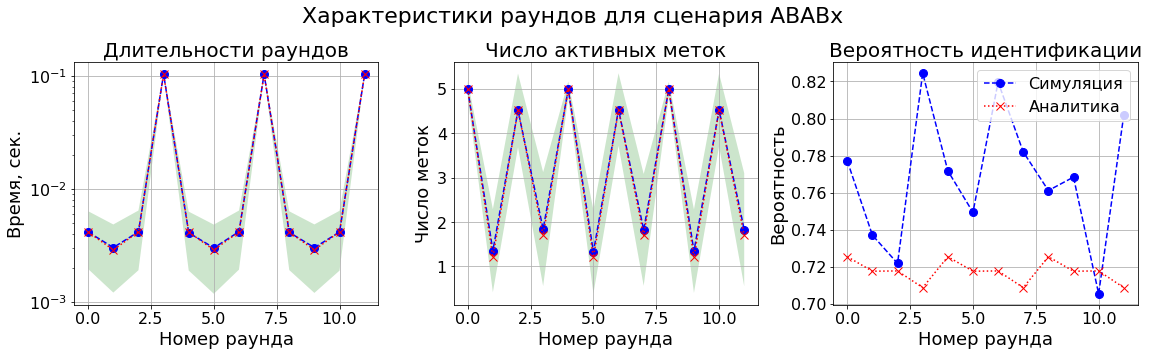

In [17]:
plot_round_props(round_props, "ABABx", show_title=True, save=False)

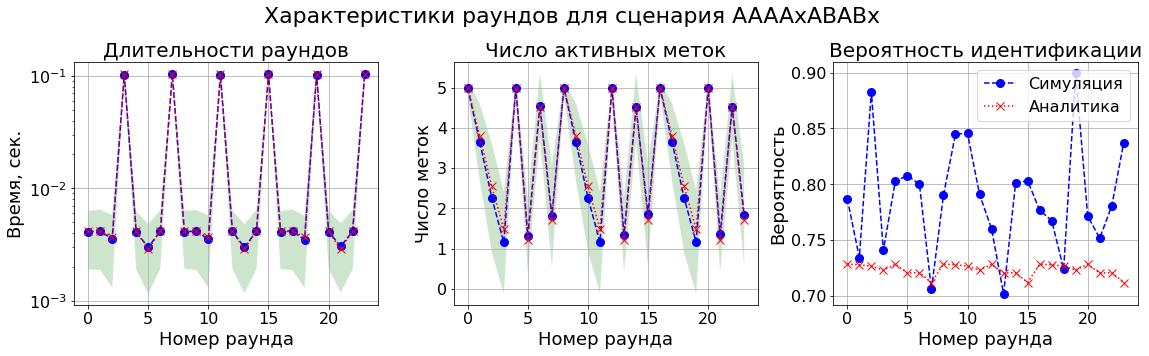

In [18]:
plot_round_props(round_props, "AAAAxABABx", show_title=True, save=False)

Из графиков можно видеть, что ошибка в оценке длительностей раундов и числа активных меток (они связаны детерминированно) очень мала. Вероятность идентификации, предсказанная аналитического моделью, оказывается немного ниже оценки, полученной из имитационной модели.

In [19]:
round_props_err = []
for scenario, props in round_props.items():
    n = len(parse_scenario(scenario)) * ROLL_SCENARIO_KOEF
    durations_errors = [rel_err(xa, xs) for xa, xs in zip(
        props['sim']['durations'].means, props['ana']['durations'].means)]
    n_active_tags_errors = [rel_err(xa, xs) for xa, xs in zip(
        props['sim']['n_tags'].means, props['ana']['n_tags'].means)]
    p_id_errors = [rel_err(xa, xs) for xa, xs in zip(
        props['sim']['p_id'], props['ana']['p_id'].means)]
    round_props_err.append((
        scenario, 
        np.mean(durations_errors),
        np.mean(n_active_tags_errors),
        np.mean(p_id_errors)
    ))
print(hl('> Estimation errors:\n', bcolors.BOLD))
print(tabulate(round_props_err, headers=(
    'Scenario', 
    'Round duration', 
    'Num. active tags',
    'ID probability'
)))

> Estimation errors:

Scenario      Round duration    Num. active tags    ID probability
----------  ----------------  ------------------  ----------------
ABABx              0.0141592           0.0484058         0.0740692
AAAAxABABx         0.0147523           0.0700865         0.0923406


## Оценка вероятности идентификации

Теперь мы можем вычислить вероятность успешной идентификации при различных сценариях, величине BER и интенсивности поступления меток, и проанализировать, как влияют периодические сбросы питания и смены флага опроса на эффективность системы.

Будем рассматривать четыре группы сценариев:

1. `'A...A'`: худший случай - считыватель всегда проводит опрос по флагу `A`.
2. `'A...Ax'`: считыватель проводит опрос по флагу `A`, но периодически сбрасывает питание (каждый 1, 2 или 4 раунда).
3. `'A..AB..B'`: считыватель не сбрасывает питание, но периодически инвертирует флаг (каждый 1, 2 или 4 раунда).
4. `'AAABxAAxABABx'`: пример нетривиального сценария со сбросами питания и инвертированием флага опроса.

Величину BER будем анализировать в достаточно широком диапазоне (до 0.05). Однако в реальности наибольший интерес представляют значения до 0.02, так как при большем BER сигнал, скорее всего, слишком слаб, чтобы запитать метку. Кроме того, из-за особенностей распространения сигнала движущихся объектов рядом с поверхностями (многолучевое распространение и эффект Допплера) реальная область чтения очень мала, поэтому при большом BER шансов на успешную передачу практически не будет. Поэтому, при оценке точности наибольшее внимание уделим области значений BER от 0 до 0.02.

In [20]:
WILL_RUN = not os.path.exists(CSV_FILE_NAME) or FORCE_COMPUTE

print(tabulate([
    (f'File "{CSV_FILE_NAME}" exists', fmt_yesno(os.path.exists(CSV_FILE_NAME))),
    (f'Force computation', fmt_yesno(FORCE_COMPUTE))
]))

if WILL_RUN:
    print(hl(f'I will be run all and write results to "{CSV_FILE_NAME}".', 
             bcolors.WARNING))
else:
    print(hl(f'I will use data from file "{CSV_FILE_NAME}"',
            bcolors.OKCYAN))

------------------------------  ---
File "data/id_prob.csv" exists  Yes
Force computation               No
------------------------------  ---
I will use data from file "data/id_prob.csv"


### Выполнение моделей

Если `WILL_RUN = True`, то нужно выполнить все эксперименты и записать результаты в файл `CSV_FILE_NAME`.

В Jupyter сложно включить многопроцессорную обработку с помощью модуля `multiprocessing`. Поэтому приходится выносить скрипт, выполняющий расчет, в отдельный файл, а данные ему передавать с помощью аргументов командной строки. Мы будем пользоваться основным скриптом `rfidam`, который определяет две команды:

- `rfidam batch solve`
- `rfidam batch simulate`

Первая команда выполняет аналитический расчет с мета- и гиперпараметрами, передаваемыми в качестве аргументов, а вторая - выполняет имитационную модель. Свободные параметры берутся из CSV-файла, в который также записываются результаты. Все вычисления производятся параллельно, используя `N_WORKERS` процессоров. Поэтому перед вызовом мы должны сформировать CSV-файл, записать в него сетку значений свободных параметров, и после этого вызвать скрипт для расчета.

In [21]:
if WILL_RUN:
    # Определяем DataFrame с сеткой свободных параметров.
    # К определенным выше параметрам добавляется вспомогательный четвертый
    # (ID_type \in {"EPCID", "TID"}), который указывает, как идентифицируется
    # метка - по EPCID или по TID.
    with open(CSV_FILE_NAME, 'w') as f:
        dr_s = symbols.DR.str(DR)
        m_s = symbols.TagEncoding.str(M)
        trext_i = 1 if TREXT else 0
        
        # Сначала запишем строки-комментарии с метапараметрами.
        # Таких строк 13.
        f.writelines([
            f"# N_SIM_TAGS = {N_SIM_TAGS}\n",
            f"# EXT_SCENARIO_MULT = {EXT_SCENARIO_MULT}\n",
            f"# TARI = {TARI}\n",
            f"# RTCAL = {RTCAL}\n",
            f"# TRCAL = {TRCAL}\n",
            f"# Q = {Q}\n",
            f"# T_OFF = {T_OFF}\n",
            f"# M = {m_s}\n",
            f"# DR = {dr_s}\n",
            f"# TREXT = {trext_i}\n",
            f"# N_DATA_WORDS = {N_DATA_WORDS}\n",
            f"# N_EPCID_BYTES = {N_EPCID_BYTES}\n",
            f"# TIME_IN_AREA = {TIME_IN_AREA}\n",
        ])
        
        # Теперь запишем сетку:
        pd.DataFrame([
            {
                # Сетка свободных параметров:
                'ber': ber,
                'interval': interval,
                'scenario': scenario,
                'id_type': id_type,
                # Колонки, в которые скрипты запишут результаты:
                'p_sim': 0.0,  # вероятность идентификации из симуляции
                'p_ana': 0.0,  # вероятность идентификации из аналитики
                't_sim': 0.0,  # сколько времени заняла симуляция
                't_ana': 0.0,  # сколько времени занял аналитический расчет
            }
            for ber, interval, scenario, id_type in itertools.product(
                BER, 
                ARRIVAL_INTERVALS, 
                SCENARIOS, 
                ["EPCID", "TID"]
            )
        ]).to_csv(f, index=False)
    
    # Выполняем симуляции. Все мета- и гиперпараметры - через аргументы команды.
    print(hl(f"[*] running simulations", bcolors.BOLD))
    %run ../rfidam/main.py batch simulate $CSV_FILE_NAME --jupyter -j $N_WORKERS \
        --num-tags $N_SIM_TAGS --tari $TARI --rtcal $RTCAL --trcal $TRCAL -q $Q \
        --tag-encoding $M.value --dr $dr_s --trext $trext_i \
        --time-in-area $TIME_IN_AREA --time-off $T_OFF
    
    # Выполняем аналитический расчет. Все, кроме свободных параметров - 
    # через аргументы команды.
    print(hl(f"[*] running analytics", bcolors.BOLD))
    %run ../rfidam/main.py batch solve $CSV_FILE_NAME --jupyter -j $N_WORKERS \
        --ext-mul $EXT_SCENARIO_MULT --tari $TARI --rtcal $RTCAL --trcal $TRCAL -q $Q \
        --tag-encoding $M.value --dr $dr_s --trext $trext_i \
        --time-in-area $TIME_IN_AREA --time-off $T_OFF
else:
    print(hl(f"[=] nothing to be executed (WILL_RUN = False)", bcolors.WARNING))

[=] nothing to be executed (WILL_RUN = False)


### Загрузка результатов

После выполнения расчетов результаты симуляции и сетка свободных параметров оказываются в файле `CSV_FILE_NAME`. Кроме того, мета- и гиперпараметры записаны в виде комментариев в первых 13 строках. Загрузим данные из файла и выведем их.

> **ВНИМАНИЕ!** После загрузки значения параметров, определенные ранее, могут измениться.

In [22]:
with open(CSV_FILE_NAME, 'r') as f:
    comments = [f.readline() for _ in range(13)]
    comments = [comment.lstrip("#") for comment in comments]
    comments = [[s.strip() for s in comment.split("=")] for comment in comments]
    # Теперь comments = [["X", "10"], ["Y", "20"], ...]
    for (key, value) in comments:
        if key == "N_SIM_TAGS": N_SIM_TAGS = int(value)
        elif key == "EXT_SCENARIO_MULT": EXT_SCENARIO_MULT = int(value)
        elif key == "TARI": TARI = float(value)
        elif key == "RTCAL": RTCAL = float(value)
        elif key == "TRCAL": TRCAL = float(value)
        elif key == "Q": Q = int(value)
        elif key == "T_OFF": T_OFF = float(value)
        elif key == "M": M = symbols.TagEncoding.parse(value)
        elif key == "DR": DR = symbols.DR.parse(value)
        elif key == "TREXT": TREXT = bool(int(value))
        elif key == "N_DATA_WORDS": N_DATA_WORDS = int(value)
        elif key == "N_EPCID_BYTES": N_EPCID_BYTES = int(value)
        elif key == "TIME_IN_AREA": TIME_IN_AREA = float(value)
    
    DF = pd.read_csv(f)

ARRIVAL_INTERVALS = list(DF.interval.unique())
SCENARIOS = list(DF.scenario.unique())
BER = list(DF.ber.unique())

ARRIVAL_INTERVALS.sort()
BER.sort()

print(hl("> Meta and hyper-parameters:", bcolors.BOLD))
print(tabulate((
    ("N_SIM_TAGS", N_SIM_TAGS),
    ("EXT_SCENARIO_MULT", EXT_SCENARIO_MULT),
    ("TARI", TARI),
    ("RTCAL", RTCAL),
    ("TRCAL", TRCAL),
    ("Q", Q),
    ("T_OFF", T_OFF),
    ("M", M),
    ("DR", DR),
    ("TREXT", TREXT),
    ("N_DATA_WORDS", N_DATA_WORDS),
    ("N_EPCID_BYTES", N_EPCID_BYTES),
    ("TIME_IN_AREA", TIME_IN_AREA),
)))
print(hl("> Parameters grid:", bcolors.BOLD))
print(tabulate((
    ("BER", BER),
    ("ARRIVAL_INTERVALS", ARRIVAL_INTERVALS),
    ("SCENARIOS", SCENARIOS)
)))

> Meta and hyper-parameters:
-----------------  ----------------------
N_SIM_TAGS         3000
EXT_SCENARIO_MULT  2000
TARI               1.25e-05
RTCAL              3.7500000000000003e-05
TRCAL              5.6250000000000005e-05
Q                  2
T_OFF              0.1
M                  TagEncoding.M2
DR                 DR.DR_643
TREXT              False
N_DATA_WORDS       4
N_EPCID_BYTES      12
TIME_IN_AREA       2.5
-----------------  ----------------------
> Parameters grid:
-----------------  ------------------------------------------------------------------------------------------------------------------------------------------------------
BER                [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325, 0.035, 0.0375, 0.04, 0.0425, 0.045, 0.0475, 0.05]
ARRIVAL_INTERVALS  [0.2, 0.4, 1.0]
SCENARIOS          ['Ax', 'AAx', 'AAAAx', 'AB', 'AAAABBBB', 'A', 'ABABx', 'AAAAxABABx']
-----------------  ----------------------------

### Визуализация результатов

Сначала рассмотрим все исследованные сценарии и сравним результаты имитационного и аналитического моделирования.

In [23]:
def plot_id_probs(scenarios, show_suptitle=False, save=False, fmt="pdf"):
    if isinstance(scenarios, str):
        scenarios = [scenarios]
    n_scenarios = len(scenarios)
    n_intervals = len(ARRIVAL_INTERVALS)

    sim_epc_kwargs = {'linestyle': '', 'marker': 'v', 'markersize': 6, 'color': CMAP(0.2)}
    sim_tid_kwargs = {'linestyle': '', 'marker': '^', 'markersize': 6, 'color': CMAP(0.8)}
    ana_epc_kwargs = {'linestyle': '--', 'color': CMAP(0.2)}
    ana_tid_kwargs = {'linestyle': '-', 'color': CMAP(0.8)}

    fig, big_axes = plt.subplots(figsize=(18, 3.7*n_scenarios), ncols=1,
                                 nrows=n_scenarios, sharey=True)
    if n_scenarios == 1:
        big_axes = [big_axes]

    for i, (scenario, big_ax) in enumerate(zip(scenarios, big_axes)):
        if show_suptitle:
            big_ax.set_title(f'Сценарий "{scenario}"\n')
        big_ax.axis('off')
        big_ax._frameon = False
    
        _df = DF[DF.scenario == scenario]
        _dfs_tid, _dfs_epc = [], []
        for j, interval in enumerate(ARRIVAL_INTERVALS):
            _dt = _df[(_df.interval == interval) & (_df.id_type == "TID")]
            _de = _df[(_df.interval == interval) & (_df.id_type == "EPCID")]
            ax = fig.add_subplot(n_scenarios, n_intervals, i * n_intervals + j + 1)

            ax.plot(_dt.ber, _dt.p_ana, **ana_tid_kwargs, label="TID (аналитика)")
            ax.plot(_dt.ber, _dt.p_sim, **sim_tid_kwargs, label="TID (симуляция)")
            ax.plot(_de.ber, _de.p_ana, **ana_epc_kwargs, label="EPCID (аналитика)")
            ax.plot(_de.ber, _de.p_sim, **sim_epc_kwargs, label="EPCID (симуляция)")

            ax.set_title(f"Интервал {interval} сек.", fontsize=18)
            ax.tick_params(labelsize=14)
            ax.set_xlabel("BER", fontsize=16)
            ax.grid()
            if i == 0 and j == len(ARRIVAL_INTERVALS)-1:
                ax.legend(bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join('images', f"id_prob_{scenario}.{fmt}"))

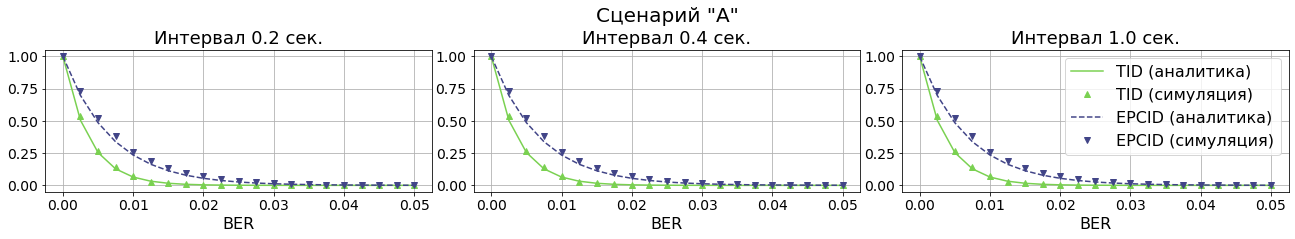

In [24]:
plot_id_probs("A", show_suptitle=True, save=False)

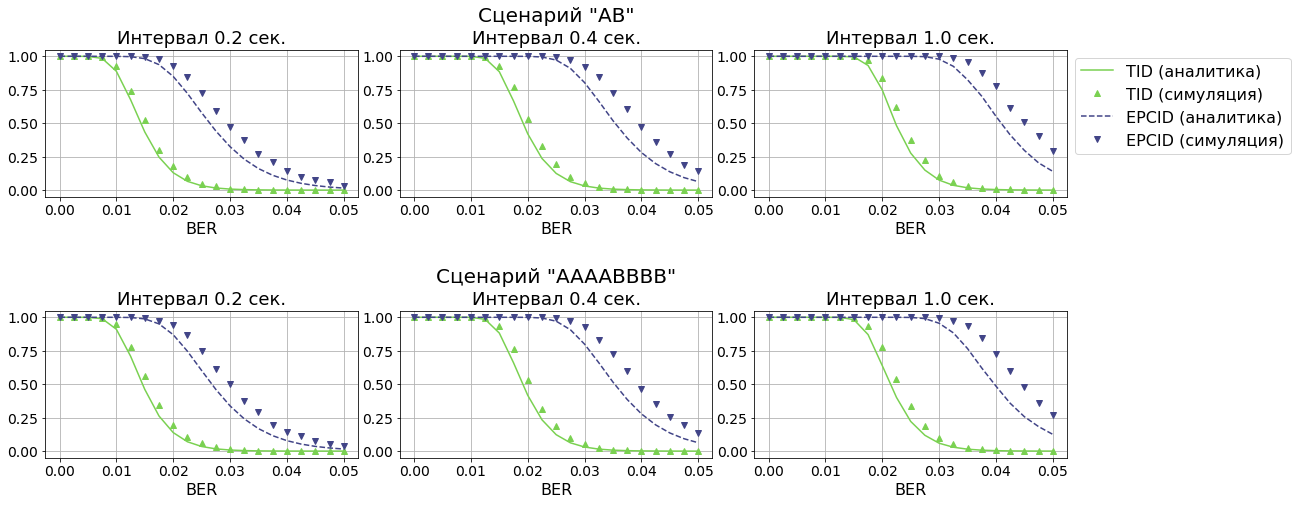

In [25]:
plot_id_probs(["AB", "AAAABBBB"], show_suptitle=True, save=False)

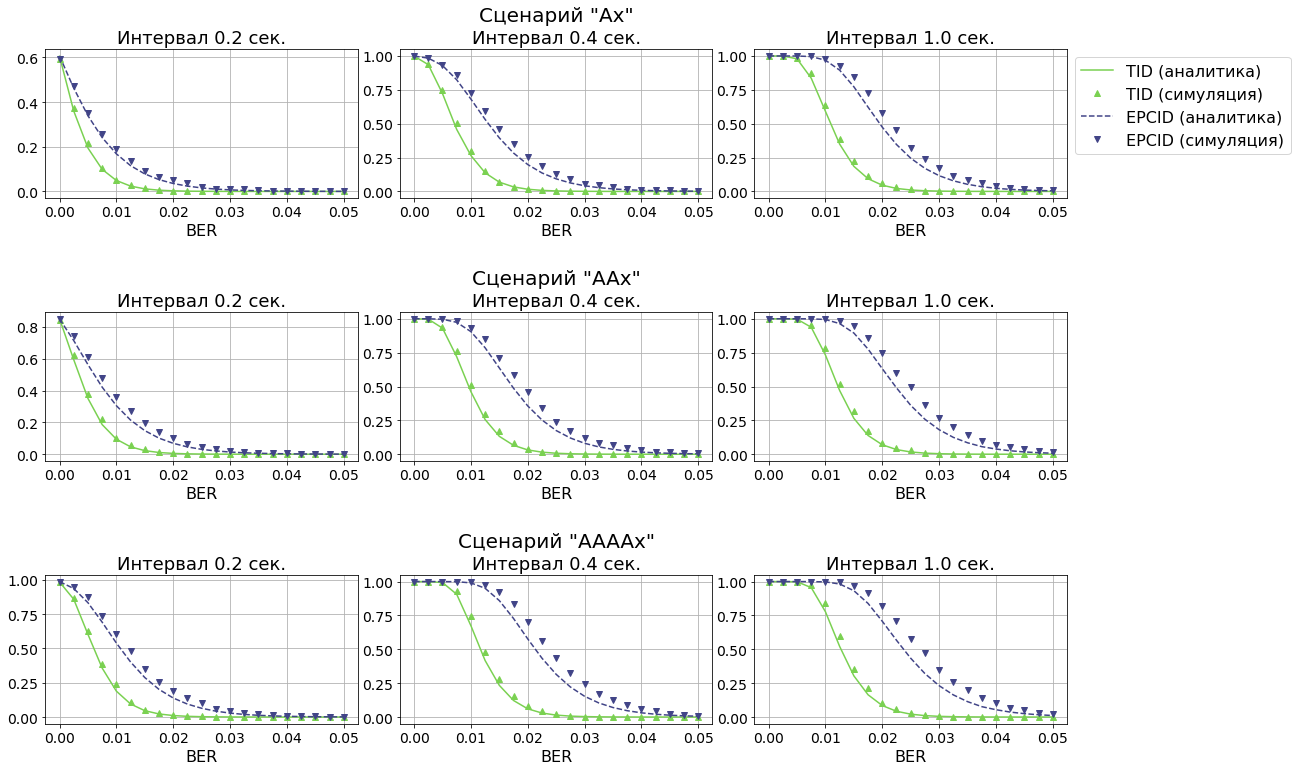

In [26]:
plot_id_probs(["Ax", "AAx", "AAAAx"], show_suptitle=True, save=False)

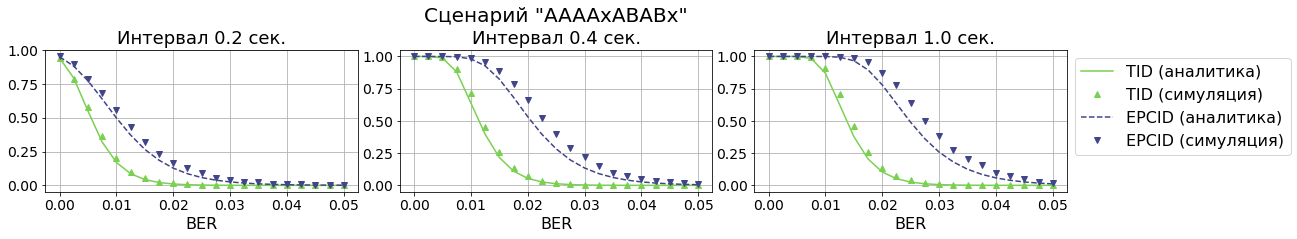

In [27]:
plot_id_probs("AAAAxABABx", show_suptitle=True, save=False)

Из приведенных графиков можно видеть, что результаты аналитической модели достаточно близки к имитационной модели. 

При `BER > 0.02` возникает некоторая системная погрешность, которая тем меньше, чем больше меток (то есть меньше интервал между ними).
Также системная погрешность оказывается меньше при сбросах питания, чем при инвертировании флага.

Относительно этой погрешности отметим три вещи. 

1. Во-первых, оценка из аналитической модели оказывается всегда меньше, чем оценка из имитационной модели. 
2. Во-вторых, при BER > 0.02 вероятность идентификации все равно слишком низкая, чтобы использовать такие каналы на практике.
3. Погрешность при идентификации по EPCID меньше, чем при идентификации по TID.

Для наглядности сравним результаты аналитической модели в различных сценариях.

In [28]:
def plot_id_probs_2(scenarios, intervals, save=False, fmt="pdf"):
    if isinstance(scenarios, str):
        scenarios = [scenarios]
    ns = len(scenarios)
    ni = len(intervals)
    
    cmap = plt.get_cmap('Greys')
    sim_kwargs = {'linestyle': ':', 'linewidth': 1, 'markersize': 8}
    ana_kwargs = {'linewidth': 2}
    sim_epc_kwargs = {**sim_kwargs, 'marker': 'v', 'color': cmap(0.6)}
    sim_tid_kwargs = {**sim_kwargs, 'marker': '^', 'color': cmap(1.0)}
    ana_epc_kwargs = {**ana_kwargs, 'linestyle': '--', 'color': cmap(0.6)}
    ana_tid_kwargs = {**ana_kwargs, 'linestyle': '-', 'color': cmap(1.0)}

    fig, axes = plt.subplots(figsize=(12.5, 2.1*ns), ncols=ni, nrows=ns, sharey=True, sharex=True)
    for i, scenario in enumerate(scenarios):
        axes[i][0].set_ylabel(f'"{scenario}"\n')
        df = DF[DF.scenario == scenario]    
        for j, interval in enumerate(intervals):
            dt = df[(df.interval == interval) & (df.id_type == "TID")]
            de = df[(df.interval == interval) & (df.id_type == "EPCID")]
            ax = axes[i][j]
            ax.plot(dt.ber, dt.p_ana, **ana_tid_kwargs, label="TID (аналитика)")
            ax.plot(dt.ber, dt.p_sim, **sim_tid_kwargs, label="TID (симуляция)")
            ax.plot(de.ber, de.p_ana, **ana_epc_kwargs, label="EPCID (аналитика)")
            ax.plot(de.ber, de.p_sim, **sim_epc_kwargs, label="EPCID (симуляция)")
            ax.grid()
    
    fig.legend(*ax.get_legend_handles_labels(), loc='lower center', 
               bbox_to_anchor=(0.5, -0.07), ncol=4)
        
    for i, interval in enumerate(intervals):
        axes[0][i].set_title(f"Интервал {interval} сек.")
        axes[-1][i].set_xlabel('BER')
    
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join('images', f"id_probs.{fmt}"))

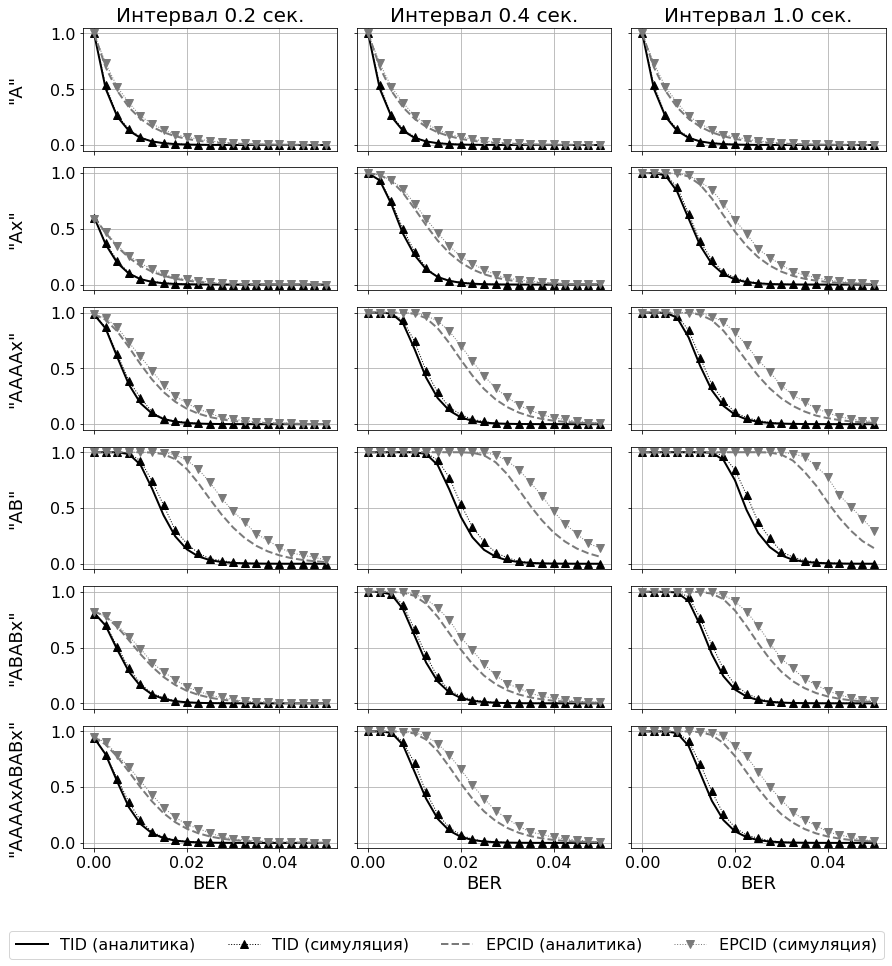

In [29]:
plot_id_probs_2(['A', 'Ax', 'AAAAx', 'AB', 'ABABx', 'AAAAxABABx'], [0.2, 0.4, 1.0])

In [30]:
def plot_analytics(save=False, fmt='pdf'):
    n_intervals = len(ARRIVAL_INTERVALS)
    OX_MAX_BER = 0.02
    ox = [x for x in BER if x <= OX_MAX_BER]
    scenarios = ["A", "Ax", "AAAAx", "ABABx", "AB", "AAAABBBB"]
    markers = ['X', 'd', 'v', '^', 'o', '*', 'D']
    styles = ['-', '--', '-.', ':']

    fig, axes = plt.subplots(figsize=(12.5, 6), ncols=n_intervals, nrows=2, sharey=True, sharex=True)
    handles, labels = [], []
    
    for i, id_type in enumerate(['EPCID', 'TID']):
        for j, interval in enumerate(ARRIVAL_INTERVALS):
            _df = DF[(DF.interval == interval) & (DF.id_type == id_type) & (DF.ber <= OX_MAX_BER)]
            ax = axes[i, j]
            for k, scenario in enumerate(scenarios):
                marker = markers[k % len(markers)]
                style = styles[k % len(styles)]
                ax.plot(
                    ox, _df[_df.scenario == scenario].p_ana, 
                    color=plt.get_cmap('Greys')(0.5 + k / len(scenarios) * 0.5),
                    marker=marker, linestyle=style, linewidth=2, markersize=10, 
                    label=scenario)                
                if i == 0:
                    ax.set_title(f'Интервал {interval} сек.')
                elif i == 1:
                    ax.set_xlabel('BER')
                if j == 0:
                    ax.set_ylabel(f'Вероятность\n(чтение {id_type})')
            ax.grid()
            
            # Store handles only once:
            if i == 0 and j == 0:
                _handles, _labels = ax.get_legend_handles_labels()
                handles.extend(_handles)
                labels.extend(_labels)

    fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.1))
    plt.tight_layout()
    if save:
        plt.savefig(f'images/analytic_id_prob.{fmt}')

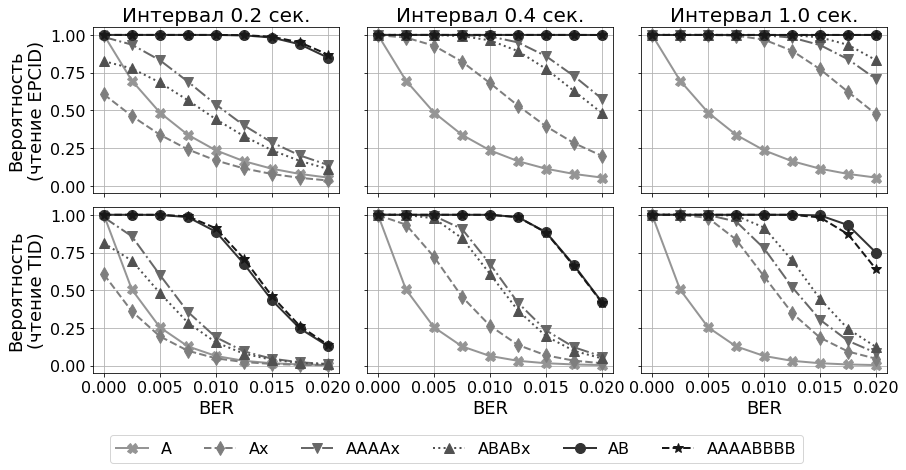

In [31]:
plot_analytics(save=False)

Теперь более подробно изучим величину ошибки. Так как для EPCID и TID она явно отличается, будем рассматривать эти случаи отдельно.

In [32]:
def get_scenario_type(scenario):
    n = len(scenario)
    if scenario[-1] == 'x' and scenario[:-1] == 'A'*(n-1):
        return "Отключение питания"
    h = n // 2
    if n % 2 == 0 and scenario[:h] == 'A'*h and scenario[h:] == 'B'*h:
        return "Смена флага опроса"
    return "Прочие"

DF['rel_err'] = DF.apply(lambda row: rel_err(row.p_sim, row.p_ana), axis=1)
DF['sc_type'] = DF.apply(lambda row: get_scenario_type(row.scenario), axis=1)
DF['abs_err'] = DF.apply(lambda row: abs(row.p_sim - row.p_ana), axis=1)

def plot_errs(err_type, max_y=None, save=False, fmt='pdf'):
    err_col = f'{err_type}_err'
    fig, axes = plt.subplots(figsize=(12.5, 6), ncols=2, nrows=2, sharey=True, gridspec_kw={'width_ratios': [1.5, 1]})
    
    handles, labels = [], []
    
    for i, id_type in enumerate(['EPCID', 'TID']):
        left_ax = axes[i][0]
        df = DF[(DF.id_type == id_type) & (DF.ber <= 0.02) & (DF.sc_type != "")]
        sns.boxplot(x='ber', y=err_col, hue='sc_type', data=df, 
                        ax=left_ax, showfliers=False, palette='Greys')
        left_ax.legend().set_visible(False)
        left_ax.set_xlabel('')
        left_ax.set_ylabel(f'Ошибка\n(чтение {id_type})')
        left_ax.grid()
        for j, tick in enumerate(left_ax.xaxis.get_major_ticks()):
            if j % 2 == 1:
                tick.label1.set_visible(False)

        right_ax = axes[i][1]
        sns.scatterplot(x='p_sim', y=err_col, hue='sc_type', data=df, ax=right_ax, s=100, 
                        palette='Greys')
        right_ax.legend().set_visible(False)
        right_ax.set_xlabel('')
        right_ax.grid()
        
        if max_y:
            left_ax.set_ylim([0, max_y])
            right_ax.set_ylim([0, max_y])
        
        if i == 0:
            _handles, _labels = left_ax.get_legend_handles_labels()
            handles.extend(_handles)
            labels.extend(_labels)
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=16)

    axes[-1][0].set_xlabel('BER')
    axes[-1][1].set_xlabel('Вероятность идентификации (сим.)')
    plt.tight_layout()
    if save:
        plt.savefig(f'images/{err_type}_errors.{fmt}')

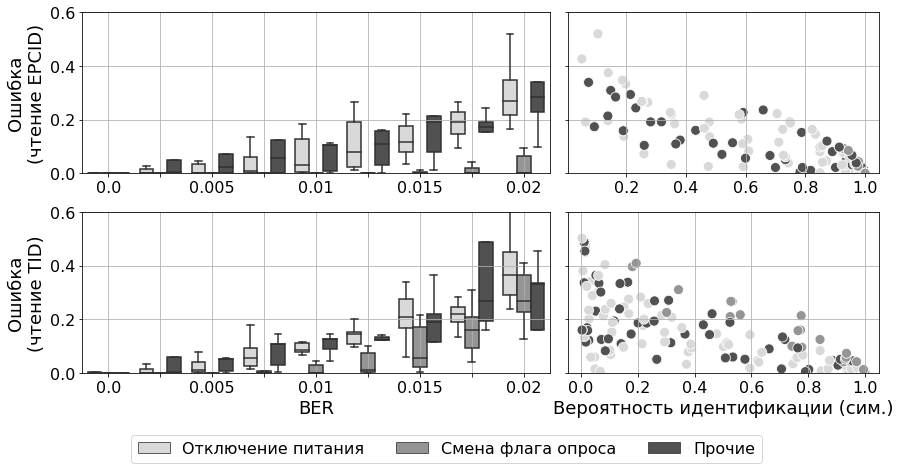

In [33]:
plot_errs('rel', max_y=0.6, save=False)

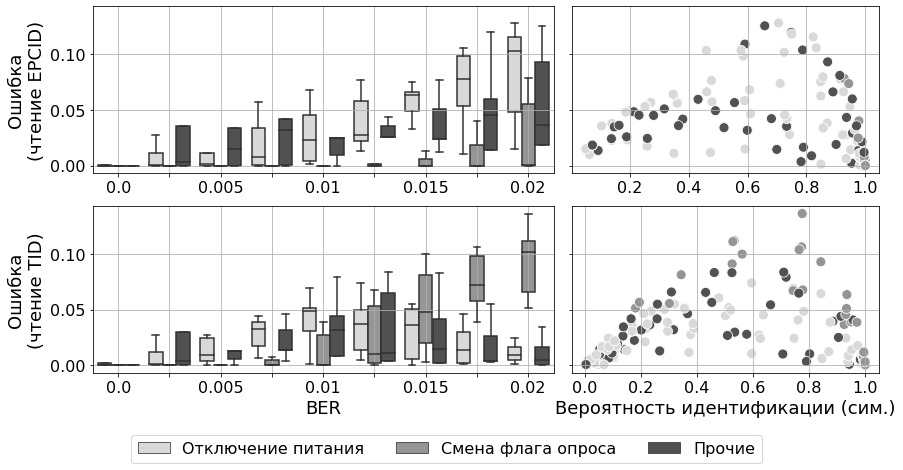

In [34]:
plot_errs('abs', save=False)